In [1]:
from __future__ import print_function, division

# Skimage
from skimage import io,transform
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms, utils
from PIL import Image
# Utils
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import os
import shutil
import pickle
from math import exp
from itertools import compress
import glob
from IPython.display import clear_output
# Help me see the estimate of completing time
from tqdm import *

plt.ion()   # interactive mode

os.chdir("C:/TalkingData/PackageName Combine")

Because the original metaid value range from 1 to 1000006, if we don't do anything. The neural network will create 1000006 neurons on the last fully-connected layer. And many of them are potentionally not going to get activated, which is a waste of resources and also can potentionally distract the correct prediction (because in theory, every neuron is possible to get activated)

Therefore, we will shrink down the possible range of value for metaid

In [ ]:
# Create metaid->y_value mapping
metaid_y = {}
counter = 1
# The sorted() is making sure the way of reading files is identical everywhere (ex. "1_1.jpg","2_1.jpg","2_2.jpg","3_1.jpg")
# Sometimes due to different os or machines, the behavior of os.listdir() is not the same
for filename in tqdm(sorted(os.listdir("./train"))):
    metaid_str = filename.split("_")[0]
    if metaid_str not in metaid_y:
        metaid_y[metaid_str] = str(counter)
        counter += 1

In [3]:
# Create y->metaid mapping
y_metaid = {v:k for k,v in metaid_y.items()}

In [4]:
# How many classes we have
len(metaid_y)

10826

In [5]:
class IconDataset(Dataset):
    
    def __init__(self, root_dir, transform = None):
        self.file_list = os.listdir(root_dir)
        self.transform = transform
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        os.chdir(self.root_dir)
        img_name = self.file_list[idx]
        label = img_name.split("_")[0]
        label = metaid_y[label]
        label = np.array(label, dtype=np.int64)
        label = torch.from_numpy(label)
        
        # First try cv2 for reading image
        try:
            image = cv2.imread(img_name,cv2.IMREAD_UNCHANGED)
            
            # Sometimes cv2 won't work but does not raise any warning until you call that variable. 
            # You will find NoneType when you try to retrieve the value
            # So check if the value is NoneType now
            if image is None:
                try:
                    # Try skimage for reading image
                    image = io.imread(img_name)
                except Exception as err:
                    # For debug
                    print('Both cv2 and skimage failed to read in. Label num: {}'.format(label))  
                    raise err
                    
        # If cv2 doesn't work, try skimage
        except:
            try:
                image = io.imread(img_name)
            # If it still doesn't work, print out the label (first part in filename) for debug
            except:
                # For debug
                print('Both cv2 and skimage failed to read in. Label num: {}'.format(label)) 
                raise err
        
        # Perform transformations on the iamge
        if self.transform:
            try:
                image = self.transform(image)
            except Exception as err:
                # For debug
                print(image.shape)
                print('Unable to perform transformation.\nimage type:{}\timage shape:{}\tLabel num: {}'.format(
                    type(image),image.shape,label)) 
                raise err
        
        # Output
        sample = [image,label]
        
        return sample

In [6]:
class CleanImage(object):
    """1. Copy gray scale image 3 times to make it 3 dimensional
       2. Deal with the alpha channel
       3. Remove the alpha channel
       4. Make sure the image has value type of uint8 (prepare for PIL transformation)
    """
    
    def __call__(self,image):
        
        # Make sure the image is in numpy array
        image = np.array(image)
        
        # Sometimes the image is only in 2-dimension, usually gray scale image, convert it to 3-dimensions matrix
        if image.ndim < 3:
            image = image.reshape(image.shape[0],image.shape[1],1)
            image = np.repeat(image, repeats=3, axis=2)
            
        # If the image has 4 channels, deal with the alpha channel
        if image.shape == 4:
            try:
                # Modify the alpha channel (Transparency)
                # Change all zero value in alpha channel to value of 255 
                # (0 means 100% transparency -> you can't see anything, 
                #  255 means 0% transparency -> the alpha channel does nothing to your visual)
                image[image[:,:,3] == 0] = [0,0,0,255]
                image = image.transpose((2, 0, 1))
            # For debug purpose
            except Exception as err:
                print(image.shape)
                raise err

        # Remove the alpha channel
        try:
            # Only keep first 3 channels
            image = image[:,:,:3]
        except Exception as err:
            # For debug
            print(image.shape)
            raise err
        
        if image.ndim == 3:
            # Before going through PIL transform, change the image type to uint8. Because it doesn't like other types :(
            image = image.astype(np.uint8)
        else:
            # For debug purpose
            print(image.shape)
            return
        
        return image

In [7]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        
        # Make sure the image is in numpy array
        image = np.array(image)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return torch.from_numpy(image.astype(np.float32))

In [8]:
# Prepare the train data loader
train_image = IconDataset("C:/TalkingData/PackageName Combine/train",
                          transform = transforms.Compose([
                              CleanImage(),
                              transforms.ToPILImage(),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(10),
                              transforms.Resize([50,50]),
                              ToTensor()
                          ]))
trainloader = DataLoader(train_image, batch_size = 10, shuffle = True)

In [9]:
# get some random training images
trainiter = iter(trainloader)
train_images, train_labels = trainiter.next()

In [10]:
# Helper function to see image in torch type
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Labels:    664  9649   987  6892


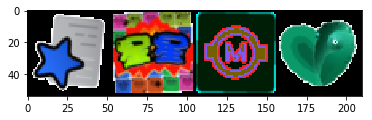

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Just see the first 4 images
images = images[0:4]
labels = labels[0:4]

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print('Labels: ', ' '.join('%5s' % labels[j].tolist() for j in range(4)))

In [12]:
def GlobalAvgPool(x):
    x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
    return x

In [13]:
# 4-convolution layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        self.fc1 = nn.Linear(64, len(metaid_y)+1) # Number of classes + bias

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = GlobalAvgPool(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x)

In [16]:
# # 5-convolution layers
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 2)
#         self.conv2 = nn.Conv2d(6, 16, 2)
#         self.conv3 = nn.Conv2d(16, 32, 2)
#         self.conv4 = nn.Conv2d(32, 64, 2)
#         self.conv5 = nn.Conv2d(64,128,2)
#         self.fc1 = nn.Linear(128, len(metaid_y)+1) # Number of classes + bias

#     def forward(self, x):
#         in_size = x.size(0)
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = GlobalAvgPool(x)
#         x = x.view(in_size, -1)
#         x = self.fc1(x)
#         return F.log_softmax(x)

In [14]:
def train_model(net,dataloader, epoch_num, nn, modelname):
    """This function train the convolutional neural network and write the loss and runtime to log files."""
    
    os.chdir("C:/TalkingData/PackageName Combine/log")
    start = time.time()
    
    with open(modelname+'_loss','w') as loss_log, open(modelname+'_runtime','w') as runtime_log:
        for epoch in range(epoch_num):  # loop over the dataset multiple times
            # Current epoch start time
            epoch_start = time.time()
            # Initialize running_loss
            running_loss = 0.0
            # Feed data to the cnn by batch
            for i, data in tqdm(enumerate(dataloader, 0)):
                # get the inputs
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                try:
                    outputs = nn(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                except Exception as err:
                    print(labels)
                    raise err

                # print statistics
                running_loss += loss.item()
                # Record the loss every 100 mini-batches
                if i % 100 == 0:    
                    # Write the loss to log file
                    loss_log.write("%d,%d,%.3f\n" % (epoch+1, i+1, running_loss / 100))
                    # Re-initialize the loss
                    running_loss = 0.0
                    
            # Current epoch end time
            epoch_end = time.time()
            # Current epoch run time
            epoch_runtime = (epoch_end-epoch_start)/60
            print("Epoch %d: %.2f minutes\nloss: %.3f" % (epoch+1, epoch_runtime, running_loss / 34))
            # Write the epoch run time (in mins) to log file
            runtime_log.write("%d,%.2f\n" % (epoch+1, epoch_runtime))
                    
    # Close opening file streams
    loss_log.close()
    runtime_log.close()
    end = time.time()
    
    print('Finished Training! Total run time: %.2f minuets' % (end - start)/60)
    os.chdir("C:/TalkingData/PackageName Combine")
    return nn

In [15]:
# Initialize the CNN
net = Net()
# Set the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Train the CNN
trainedNet = train_model(net,trainloader,500,net,'4conv_500iter')

0it [00:00, ?it/s]C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
1134it [03:34,  5.29it/s]


Epoch 1: 3.57 minutes
loss: 9.023


1134it [03:15,  5.79it/s]


Epoch 2: 3.26 minutes
loss: 9.022


1134it [02:56,  6.41it/s]


Epoch 3: 2.95 minutes
loss: 9.016


1134it [03:07,  6.06it/s]


Epoch 4: 3.12 minutes
loss: 9.019


1134it [03:01,  6.25it/s]


Epoch 5: 3.03 minutes
loss: 9.022


1134it [02:53,  6.52it/s]


Epoch 6: 2.90 minutes
loss: 9.012


1134it [02:49,  6.68it/s]


Epoch 7: 2.83 minutes
loss: 9.016


1134it [03:00,  6.28it/s]


Epoch 8: 3.01 minutes
loss: 9.019


1134it [02:36,  7.26it/s]


Epoch 9: 2.60 minutes
loss: 9.016


1134it [02:36,  7.27it/s]


Epoch 10: 2.60 minutes
loss: 9.020


1134it [02:42,  6.97it/s]


Epoch 11: 2.71 minutes
loss: 9.023


1134it [02:35,  7.31it/s]


Epoch 12: 2.59 minutes
loss: 8.993


1134it [02:39,  7.10it/s]


Epoch 13: 2.66 minutes
loss: 9.000


1134it [02:44,  6.90it/s]


Epoch 14: 2.74 minutes
loss: 8.990


1134it [02:30,  7.51it/s]


Epoch 15: 2.52 minutes
loss: 8.988


1134it [02:44,  6.91it/s]


Epoch 16: 2.74 minutes
loss: 8.976


1134it [02:27,  7.70it/s]


Epoch 17: 2.45 minutes
loss: 8.961


1134it [02:29,  7.59it/s]


Epoch 18: 2.49 minutes
loss: 8.988


1134it [02:30,  7.56it/s]


Epoch 19: 2.50 minutes
loss: 8.943


1134it [02:31,  7.48it/s]


Epoch 20: 2.53 minutes
loss: 8.913


1134it [02:36,  7.26it/s]


Epoch 21: 2.60 minutes
loss: 8.906


1134it [02:58,  6.34it/s]


Epoch 22: 2.98 minutes
loss: 8.852


1134it [04:03,  4.67it/s]


Epoch 23: 4.05 minutes
loss: 8.843


1134it [03:52,  4.89it/s]


Epoch 24: 3.87 minutes
loss: 8.741


1134it [02:55,  6.45it/s]


Epoch 25: 2.93 minutes
loss: 8.774


1134it [02:53,  6.55it/s]


Epoch 26: 2.88 minutes
loss: 8.796


1134it [02:44,  6.91it/s]


Epoch 27: 2.74 minutes
loss: 8.714


1134it [02:36,  7.25it/s]


Epoch 28: 2.61 minutes
loss: 8.727


1134it [02:35,  7.30it/s]


Epoch 29: 2.59 minutes
loss: 8.702


1134it [02:37,  7.18it/s]


Epoch 30: 2.63 minutes
loss: 8.766


1134it [02:35,  7.31it/s]


Epoch 31: 2.59 minutes
loss: 8.656


1134it [02:41,  7.02it/s]


Epoch 32: 2.69 minutes
loss: 8.615


1134it [02:35,  7.27it/s]


Epoch 33: 2.60 minutes
loss: 8.597


1134it [04:46,  3.96it/s]


Epoch 34: 4.77 minutes
loss: 8.631


1134it [06:04,  3.12it/s]


Epoch 35: 6.07 minutes
loss: 8.559


1134it [05:52,  3.22it/s]


Epoch 36: 5.87 minutes
loss: 8.559


1134it [04:07,  4.58it/s]


Epoch 37: 4.13 minutes
loss: 8.475


1134it [02:53,  6.54it/s]


Epoch 38: 2.89 minutes
loss: 8.509


1134it [02:52,  6.58it/s]


Epoch 39: 2.87 minutes
loss: 8.419


1134it [02:52,  6.57it/s]


Epoch 40: 2.88 minutes
loss: 8.418


1134it [02:52,  6.58it/s]


Epoch 41: 2.87 minutes
loss: 8.283


1134it [02:54,  6.50it/s]


Epoch 42: 2.91 minutes
loss: 8.374


1134it [03:28,  5.43it/s]


Epoch 43: 3.48 minutes
loss: 8.332


1134it [02:45,  6.86it/s]


Epoch 44: 2.75 minutes
loss: 8.272


1134it [02:42,  6.96it/s]


Epoch 45: 2.71 minutes
loss: 8.398


1134it [02:29,  7.57it/s]


Epoch 46: 2.50 minutes
loss: 8.193


1134it [02:39,  7.10it/s]


Epoch 47: 2.66 minutes
loss: 8.031


1134it [02:30,  7.52it/s]


Epoch 48: 2.51 minutes
loss: 7.998


1134it [02:30,  7.53it/s]


Epoch 49: 2.51 minutes
loss: 8.247


1134it [02:28,  7.61it/s]


Epoch 50: 2.48 minutes
loss: 8.130


1134it [02:31,  7.50it/s]


Epoch 51: 2.52 minutes
loss: 8.155


1134it [02:29,  7.57it/s]


Epoch 52: 2.50 minutes
loss: 8.090


1134it [02:30,  7.53it/s]


Epoch 53: 2.51 minutes
loss: 8.072


1134it [02:29,  7.58it/s]


Epoch 54: 2.49 minutes
loss: 7.979


1134it [02:29,  7.60it/s]


Epoch 55: 2.49 minutes
loss: 8.041


1134it [02:29,  7.59it/s]


Epoch 56: 2.49 minutes
loss: 7.831


1134it [02:29,  7.59it/s]


Epoch 57: 2.49 minutes
loss: 7.968


1134it [02:35,  7.30it/s]


Epoch 58: 2.59 minutes
loss: 7.960


1134it [02:30,  7.52it/s]


Epoch 59: 2.51 minutes
loss: 7.774


1134it [02:29,  7.58it/s]


Epoch 60: 2.49 minutes
loss: 7.827


1134it [02:30,  7.53it/s]


Epoch 61: 2.51 minutes
loss: 7.797


1134it [02:31,  7.47it/s]


Epoch 62: 2.53 minutes
loss: 7.748


1134it [02:36,  7.24it/s]


Epoch 63: 2.61 minutes
loss: 7.558


1134it [02:35,  7.30it/s]


Epoch 64: 2.59 minutes
loss: 7.677


1134it [02:35,  7.29it/s]


Epoch 65: 2.59 minutes
loss: 7.595


1134it [02:36,  7.24it/s]


Epoch 66: 2.61 minutes
loss: 7.651


1134it [02:36,  7.24it/s]


Epoch 67: 2.61 minutes
loss: 7.544


1134it [02:44,  6.91it/s]


Epoch 68: 2.74 minutes
loss: 7.374


1134it [02:37,  7.20it/s]


Epoch 69: 2.63 minutes
loss: 7.399


1134it [02:36,  7.26it/s]


Epoch 70: 2.60 minutes
loss: 7.314


1134it [02:31,  7.46it/s]


Epoch 71: 2.53 minutes
loss: 7.347


1134it [02:23,  7.90it/s]


Epoch 72: 2.39 minutes
loss: 7.465


1134it [02:53,  6.55it/s]


Epoch 73: 2.88 minutes
loss: 7.406


1134it [02:36,  7.25it/s]


Epoch 74: 2.61 minutes
loss: 7.144


1134it [02:41,  7.02it/s]


Epoch 75: 2.69 minutes
loss: 7.235


1134it [02:49,  6.71it/s]


Epoch 76: 2.82 minutes
loss: 7.045


1134it [02:48,  6.74it/s]


Epoch 77: 2.81 minutes
loss: 7.120


1134it [02:48,  6.72it/s]


Epoch 78: 2.81 minutes
loss: 7.236


1134it [02:47,  6.75it/s]


Epoch 79: 2.80 minutes
loss: 7.265


1134it [02:33,  7.39it/s]


Epoch 80: 2.56 minutes
loss: 6.922


1134it [02:32,  7.43it/s]


Epoch 81: 2.54 minutes
loss: 7.107


1134it [02:32,  7.42it/s]


Epoch 82: 2.55 minutes
loss: 6.800


1134it [02:32,  7.43it/s]


Epoch 83: 2.55 minutes
loss: 6.947


1134it [02:33,  7.40it/s]


Epoch 84: 2.55 minutes
loss: 6.711


1134it [02:34,  7.33it/s]


Epoch 85: 2.58 minutes
loss: 6.446


1134it [02:34,  7.35it/s]


Epoch 86: 2.57 minutes
loss: 6.741


1134it [02:34,  7.36it/s]


Epoch 87: 2.57 minutes
loss: 6.331


1134it [02:33,  7.40it/s]


Epoch 88: 2.55 minutes
loss: 6.391


1134it [02:34,  7.36it/s]


Epoch 89: 2.57 minutes
loss: 6.685


1134it [02:33,  7.38it/s]


Epoch 90: 2.56 minutes
loss: 6.878


1134it [02:34,  7.35it/s]


Epoch 91: 2.57 minutes
loss: 6.083


1134it [02:33,  7.38it/s]


Epoch 92: 2.56 minutes
loss: 6.457


1134it [02:42,  6.96it/s]


Epoch 93: 2.71 minutes
loss: 6.158


1134it [02:34,  7.34it/s]


Epoch 94: 2.57 minutes
loss: 6.047


1134it [02:33,  7.39it/s]


Epoch 95: 2.56 minutes
loss: 6.316


1134it [02:33,  7.40it/s]


Epoch 96: 2.56 minutes
loss: 6.100


1134it [02:39,  7.09it/s]


Epoch 97: 2.67 minutes
loss: 5.809


1134it [02:33,  7.38it/s]


Epoch 98: 2.56 minutes
loss: 6.036


1134it [02:34,  7.36it/s]


Epoch 99: 2.57 minutes
loss: 6.120


1134it [02:33,  7.39it/s]


Epoch 100: 2.56 minutes
loss: 5.711


1134it [02:46,  6.82it/s]


Epoch 101: 2.77 minutes
loss: 5.593


1134it [02:34,  7.33it/s]


Epoch 102: 2.58 minutes
loss: 5.527


1134it [02:32,  7.41it/s]


Epoch 103: 2.55 minutes
loss: 5.466


1134it [02:33,  7.39it/s]


Epoch 104: 2.56 minutes
loss: 5.729


1134it [02:33,  7.40it/s]


Epoch 105: 2.55 minutes
loss: 5.450


1134it [02:33,  7.41it/s]


Epoch 106: 2.55 minutes
loss: 5.274


1134it [02:33,  7.39it/s]


Epoch 107: 2.56 minutes
loss: 5.414


1134it [02:33,  7.41it/s]


Epoch 108: 2.55 minutes
loss: 5.150


1134it [02:33,  7.39it/s]


Epoch 109: 2.56 minutes
loss: 4.992


1134it [02:33,  7.40it/s]


Epoch 110: 2.55 minutes
loss: 5.033


1134it [02:33,  7.41it/s]


Epoch 111: 2.55 minutes
loss: 5.202


1134it [02:32,  7.43it/s]


Epoch 112: 2.55 minutes
loss: 4.870


1134it [02:33,  7.39it/s]


Epoch 113: 2.56 minutes
loss: 4.668


1134it [02:32,  7.42it/s]


Epoch 114: 2.55 minutes
loss: 5.135


1134it [02:33,  7.41it/s]


Epoch 115: 2.55 minutes
loss: 4.635


1134it [02:32,  7.43it/s]


Epoch 116: 2.54 minutes
loss: 4.577


1134it [02:39,  7.11it/s]


Epoch 117: 2.66 minutes
loss: 4.864


1134it [02:42,  6.97it/s]


Epoch 118: 2.71 minutes
loss: 4.542


1134it [02:35,  7.28it/s]


Epoch 119: 2.60 minutes
loss: 4.487


1134it [02:35,  7.30it/s]


Epoch 120: 2.59 minutes
loss: 4.280


1134it [02:35,  7.28it/s]


Epoch 121: 2.60 minutes
loss: 4.343


1134it [02:35,  7.31it/s]


Epoch 122: 2.59 minutes
loss: 4.617


1134it [02:35,  7.29it/s]


Epoch 123: 2.59 minutes
loss: 4.314


1134it [02:35,  7.28it/s]


Epoch 124: 2.60 minutes
loss: 3.918


1134it [02:35,  7.29it/s]


Epoch 125: 2.59 minutes
loss: 4.638


1134it [02:34,  7.33it/s]


Epoch 126: 2.58 minutes
loss: 4.381


1134it [02:35,  7.31it/s]


Epoch 127: 2.59 minutes
loss: 4.458


1134it [02:35,  7.31it/s]


Epoch 128: 2.58 minutes
loss: 4.389


1134it [02:35,  7.31it/s]


Epoch 129: 2.58 minutes
loss: 4.185


1134it [02:34,  7.33it/s]


Epoch 130: 2.58 minutes
loss: 4.279


1134it [02:34,  7.32it/s]


Epoch 131: 2.58 minutes
loss: 3.909


1134it [02:35,  7.30it/s]


Epoch 132: 2.59 minutes
loss: 4.198


1134it [02:35,  7.30it/s]


Epoch 133: 2.59 minutes
loss: 3.916


1134it [02:34,  7.32it/s]


Epoch 134: 2.58 minutes
loss: 4.344


1134it [02:35,  7.31it/s]


Epoch 135: 2.58 minutes
loss: 3.955


1134it [02:34,  7.33it/s]


Epoch 136: 2.58 minutes
loss: 4.022


1134it [02:36,  7.24it/s]


Epoch 137: 2.61 minutes
loss: 3.575


1134it [02:36,  7.25it/s]


Epoch 138: 2.61 minutes
loss: 4.138


1134it [02:34,  7.33it/s]


Epoch 139: 2.58 minutes
loss: 3.608


1134it [02:34,  7.32it/s]


Epoch 140: 2.58 minutes
loss: 3.790


1134it [02:35,  7.30it/s]


Epoch 141: 2.59 minutes
loss: 3.759


1134it [02:36,  7.26it/s]


Epoch 142: 2.60 minutes
loss: 3.759


1134it [02:38,  7.16it/s]


Epoch 143: 2.64 minutes
loss: 3.523


1134it [02:38,  7.17it/s]


Epoch 144: 2.64 minutes
loss: 3.596


1134it [02:37,  7.19it/s]


Epoch 145: 2.63 minutes
loss: 3.924


1134it [02:35,  7.29it/s]


Epoch 146: 2.59 minutes
loss: 3.905


1134it [02:36,  7.26it/s]


Epoch 147: 2.60 minutes
loss: 3.313


1134it [02:36,  7.24it/s]


Epoch 148: 2.61 minutes
loss: 3.519


1134it [02:37,  7.22it/s]


Epoch 149: 2.62 minutes
loss: 3.699


1134it [02:36,  7.25it/s]


Epoch 150: 2.61 minutes
loss: 3.719


1134it [02:38,  7.17it/s]


Epoch 151: 2.64 minutes
loss: 3.082


1134it [02:36,  7.24it/s]


Epoch 152: 2.61 minutes
loss: 3.248


1134it [02:36,  7.23it/s]


Epoch 153: 2.61 minutes
loss: 3.197


1134it [02:36,  7.23it/s]


Epoch 154: 2.62 minutes
loss: 3.522


1134it [02:37,  7.22it/s]


Epoch 155: 2.62 minutes
loss: 3.333


1134it [02:36,  7.24it/s]


Epoch 156: 2.61 minutes
loss: 3.535


1134it [02:36,  7.25it/s]


Epoch 157: 2.61 minutes
loss: 3.330


1134it [02:36,  7.27it/s]


Epoch 158: 2.60 minutes
loss: 3.461


1134it [02:35,  7.28it/s]


Epoch 159: 2.60 minutes
loss: 3.267


1134it [02:36,  7.26it/s]


Epoch 160: 2.60 minutes
loss: 3.286


1134it [02:36,  7.23it/s]


Epoch 161: 2.62 minutes
loss: 3.365


1134it [02:36,  7.26it/s]


Epoch 162: 2.60 minutes
loss: 3.064


1134it [02:36,  7.26it/s]


Epoch 163: 2.61 minutes
loss: 3.181


1134it [02:36,  7.24it/s]


Epoch 164: 2.61 minutes
loss: 3.458


1134it [02:36,  7.23it/s]


Epoch 165: 2.62 minutes
loss: 3.054


1134it [02:36,  7.25it/s]


Epoch 166: 2.61 minutes
loss: 3.403


1134it [02:36,  7.23it/s]


Epoch 167: 2.61 minutes
loss: 2.809


1134it [02:37,  7.20it/s]


Epoch 168: 2.63 minutes
loss: 3.274


1134it [02:37,  7.21it/s]


Epoch 169: 2.62 minutes
loss: 2.920


1134it [02:37,  7.20it/s]


Epoch 170: 2.63 minutes
loss: 3.412


1134it [02:36,  7.23it/s]


Epoch 171: 2.62 minutes
loss: 3.127


1134it [02:37,  7.21it/s]


Epoch 172: 2.62 minutes
loss: 3.656


1134it [02:37,  7.18it/s]


Epoch 173: 2.63 minutes
loss: 3.075


1134it [02:37,  7.18it/s]


Epoch 174: 2.63 minutes
loss: 2.694


1134it [02:37,  7.20it/s]


Epoch 175: 2.63 minutes
loss: 2.961


1134it [02:38,  7.18it/s]


Epoch 176: 2.63 minutes
loss: 2.792


1134it [02:37,  7.18it/s]


Epoch 177: 2.63 minutes
loss: 3.188


1134it [02:37,  7.19it/s]


Epoch 178: 2.63 minutes
loss: 2.723


1134it [02:38,  7.17it/s]


Epoch 179: 2.64 minutes
loss: 2.757


1134it [02:38,  7.17it/s]


Epoch 180: 2.64 minutes
loss: 2.893


1134it [02:37,  7.22it/s]


Epoch 181: 2.62 minutes
loss: 2.870


1134it [02:37,  7.22it/s]


Epoch 182: 2.62 minutes
loss: 2.926


1134it [02:36,  7.24it/s]


Epoch 183: 2.61 minutes
loss: 3.205


1134it [02:37,  7.22it/s]


Epoch 184: 2.62 minutes
loss: 2.820


1134it [02:36,  7.23it/s]


Epoch 185: 2.61 minutes
loss: 2.652


1134it [02:42,  6.98it/s]


Epoch 186: 2.71 minutes
loss: 2.541


1134it [02:38,  7.17it/s]


Epoch 187: 2.64 minutes
loss: 2.680


1134it [02:37,  7.18it/s]


Epoch 188: 2.63 minutes
loss: 2.674


1134it [02:37,  7.19it/s]


Epoch 189: 2.63 minutes
loss: 2.430


1134it [02:39,  7.10it/s]


Epoch 190: 2.66 minutes
loss: 2.599


1134it [02:39,  7.09it/s]


Epoch 191: 2.66 minutes
loss: 2.778


1134it [02:38,  7.13it/s]


Epoch 192: 2.65 minutes
loss: 2.461


1134it [02:38,  7.16it/s]


Epoch 193: 2.64 minutes
loss: 2.679


1134it [02:38,  7.15it/s]


Epoch 194: 2.64 minutes
loss: 2.179


1134it [02:38,  7.17it/s]


Epoch 195: 2.64 minutes
loss: 2.508


1134it [02:38,  7.14it/s]


Epoch 196: 2.65 minutes
loss: 2.872


1134it [02:38,  7.15it/s]


Epoch 197: 2.64 minutes
loss: 2.224


1134it [02:38,  7.15it/s]


Epoch 198: 2.64 minutes
loss: 2.794


1134it [02:38,  7.14it/s]


Epoch 199: 2.65 minutes
loss: 2.516


1134it [02:38,  7.15it/s]


Epoch 200: 2.65 minutes
loss: 2.605


1134it [02:38,  7.16it/s]


Epoch 201: 2.64 minutes
loss: 2.588


1134it [02:39,  7.11it/s]


Epoch 202: 2.66 minutes
loss: 2.291


1134it [02:38,  7.14it/s]


Epoch 203: 2.65 minutes
loss: 2.857


1134it [02:38,  7.15it/s]


Epoch 204: 2.64 minutes
loss: 2.553


1134it [02:39,  7.12it/s]


Epoch 205: 2.65 minutes
loss: 2.341


1134it [02:38,  7.13it/s]


Epoch 206: 2.65 minutes
loss: 2.268


1134it [02:38,  7.15it/s]


Epoch 207: 2.64 minutes
loss: 2.447


1134it [02:39,  7.12it/s]


Epoch 208: 2.66 minutes
loss: 2.393


1134it [02:38,  7.14it/s]


Epoch 209: 2.65 minutes
loss: 2.241


1134it [02:39,  7.13it/s]


Epoch 210: 2.65 minutes
loss: 2.481


1134it [02:39,  7.11it/s]


Epoch 211: 2.66 minutes
loss: 2.594


1134it [02:40,  7.08it/s]


Epoch 212: 2.67 minutes
loss: 2.038


1134it [02:39,  7.11it/s]


Epoch 213: 2.66 minutes
loss: 2.461


1134it [02:41,  7.03it/s]


Epoch 214: 2.69 minutes
loss: 2.415


1134it [02:39,  7.11it/s]


Epoch 215: 2.66 minutes
loss: 2.309


1134it [02:39,  7.11it/s]


Epoch 216: 2.66 minutes
loss: 2.437


1134it [02:40,  7.07it/s]


Epoch 217: 2.67 minutes
loss: 1.969


1134it [02:39,  7.11it/s]


Epoch 218: 2.66 minutes
loss: 2.482


1134it [02:40,  7.06it/s]


Epoch 219: 2.68 minutes
loss: 2.648


1134it [02:38,  7.13it/s]


Epoch 220: 2.65 minutes
loss: 2.217


1134it [02:38,  7.15it/s]


Epoch 221: 2.64 minutes
loss: 2.153


1134it [02:39,  7.13it/s]


Epoch 222: 2.65 minutes
loss: 1.950


1134it [02:39,  7.11it/s]


Epoch 223: 2.66 minutes
loss: 2.255


1134it [02:39,  7.09it/s]


Epoch 224: 2.67 minutes
loss: 2.337


1134it [02:39,  7.10it/s]


Epoch 225: 2.66 minutes
loss: 2.261


1134it [02:38,  7.14it/s]


Epoch 226: 2.65 minutes
loss: 2.393


1134it [02:39,  7.10it/s]


Epoch 227: 2.66 minutes
loss: 2.048


1134it [02:39,  7.09it/s]


Epoch 228: 2.67 minutes
loss: 2.078


1134it [02:39,  7.12it/s]


Epoch 229: 2.65 minutes
loss: 2.403


1134it [02:39,  7.09it/s]


Epoch 230: 2.66 minutes
loss: 2.199


1134it [02:40,  7.05it/s]


Epoch 231: 2.68 minutes
loss: 2.618


1134it [02:39,  7.10it/s]


Epoch 232: 2.66 minutes
loss: 1.967


1134it [02:39,  7.09it/s]


Epoch 233: 2.67 minutes
loss: 2.228


1134it [02:40,  7.09it/s]


Epoch 234: 2.67 minutes
loss: 2.665


1134it [02:41,  7.03it/s]


Epoch 235: 2.69 minutes
loss: 2.624


1134it [02:41,  7.04it/s]


Epoch 236: 2.69 minutes
loss: 2.142


1134it [02:40,  7.09it/s]


Epoch 237: 2.67 minutes
loss: 2.151


1134it [02:39,  7.09it/s]


Epoch 238: 2.67 minutes
loss: 1.898


1134it [02:40,  7.06it/s]


Epoch 239: 2.68 minutes
loss: 2.312


1134it [02:40,  7.09it/s]


Epoch 240: 2.67 minutes
loss: 1.914


1134it [02:40,  7.07it/s]


Epoch 241: 2.67 minutes
loss: 2.152


1134it [02:40,  7.05it/s]


Epoch 242: 2.68 minutes
loss: 1.891


1134it [02:40,  7.07it/s]


Epoch 243: 2.68 minutes
loss: 2.068


1134it [02:40,  7.06it/s]


Epoch 244: 2.68 minutes
loss: 2.511


1134it [02:40,  7.08it/s]


Epoch 245: 2.67 minutes
loss: 2.563


1134it [02:40,  7.07it/s]


Epoch 246: 2.68 minutes
loss: 2.059


1134it [02:40,  7.04it/s]


Epoch 247: 2.68 minutes
loss: 2.287


1134it [02:40,  7.06it/s]


Epoch 248: 2.68 minutes
loss: 1.818


1134it [02:39,  7.11it/s]


Epoch 249: 2.66 minutes
loss: 2.290


1134it [02:40,  7.08it/s]


Epoch 250: 2.67 minutes
loss: 1.956


1134it [02:39,  7.09it/s]


Epoch 251: 2.67 minutes
loss: 2.333


1134it [02:40,  7.08it/s]


Epoch 252: 2.67 minutes
loss: 1.924


1134it [02:40,  7.09it/s]


Epoch 253: 2.67 minutes
loss: 1.982


1134it [02:46,  6.80it/s]


Epoch 254: 2.78 minutes
loss: 1.983


1134it [02:40,  7.07it/s]


Epoch 255: 2.67 minutes
loss: 1.988


1134it [02:40,  7.07it/s]


Epoch 256: 2.67 minutes
loss: 1.885


1134it [02:40,  7.06it/s]


Epoch 257: 2.68 minutes
loss: 2.267


1134it [02:40,  7.05it/s]


Epoch 258: 2.68 minutes
loss: 2.165


1134it [02:41,  7.03it/s]


Epoch 259: 2.69 minutes
loss: 1.762


1134it [02:40,  7.08it/s]


Epoch 260: 2.67 minutes
loss: 2.013


1134it [02:40,  7.08it/s]


Epoch 261: 2.67 minutes
loss: 2.179


1134it [02:40,  7.07it/s]


Epoch 262: 2.67 minutes
loss: 2.020


1134it [02:40,  7.08it/s]


Epoch 263: 2.67 minutes
loss: 2.030


1134it [02:40,  7.07it/s]


Epoch 264: 2.68 minutes
loss: 1.658


1134it [02:40,  7.05it/s]


Epoch 265: 2.68 minutes
loss: 2.156


1134it [02:39,  7.11it/s]


Epoch 266: 2.66 minutes
loss: 2.072


1134it [02:39,  7.10it/s]


Epoch 267: 2.66 minutes
loss: 1.635


1134it [02:41,  7.01it/s]


Epoch 268: 2.70 minutes
loss: 1.887


1134it [02:40,  7.05it/s]


Epoch 269: 2.68 minutes
loss: 1.837


1134it [02:41,  7.04it/s]


Epoch 270: 2.69 minutes
loss: 2.240


1134it [02:42,  6.97it/s]


Epoch 271: 2.71 minutes
loss: 1.864


1134it [02:43,  6.92it/s]


Epoch 272: 2.73 minutes
loss: 1.935


1134it [02:41,  7.01it/s]


Epoch 273: 2.69 minutes
loss: 1.722


1134it [02:41,  7.02it/s]


Epoch 274: 2.69 minutes
loss: 1.592


1134it [02:40,  7.04it/s]


Epoch 275: 2.68 minutes
loss: 1.855


1134it [02:41,  7.02it/s]


Epoch 276: 2.69 minutes
loss: 1.805


1134it [02:41,  7.03it/s]


Epoch 277: 2.69 minutes
loss: 2.043


1134it [02:41,  7.04it/s]


Epoch 278: 2.68 minutes
loss: 1.817


1134it [02:42,  6.96it/s]


Epoch 279: 2.71 minutes
loss: 2.219


1134it [02:41,  7.00it/s]


Epoch 280: 2.70 minutes
loss: 2.182


1134it [02:42,  6.99it/s]


Epoch 281: 2.71 minutes
loss: 1.837


1134it [02:41,  7.03it/s]


Epoch 282: 2.69 minutes
loss: 1.805


1134it [02:40,  7.05it/s]


Epoch 283: 2.68 minutes
loss: 2.101


1134it [02:40,  7.08it/s]


Epoch 284: 2.67 minutes
loss: 2.050


1134it [02:40,  7.08it/s]


Epoch 285: 2.67 minutes
loss: 2.113


1134it [02:40,  7.08it/s]


Epoch 286: 2.67 minutes
loss: 2.007


1134it [02:40,  7.08it/s]


Epoch 287: 2.67 minutes
loss: 1.912


1134it [02:41,  7.04it/s]


Epoch 288: 2.68 minutes
loss: 1.948


1134it [02:40,  7.08it/s]


Epoch 289: 2.67 minutes
loss: 1.734


1134it [02:40,  7.07it/s]


Epoch 290: 2.67 minutes
loss: 1.552


1134it [02:40,  7.05it/s]


Epoch 291: 2.68 minutes
loss: 2.194


1134it [02:40,  7.08it/s]


Epoch 292: 2.67 minutes
loss: 1.998


1134it [02:40,  7.07it/s]


Epoch 293: 2.68 minutes
loss: 2.336


1134it [02:40,  7.06it/s]


Epoch 294: 2.68 minutes
loss: 1.920


1134it [02:40,  7.05it/s]


Epoch 295: 2.68 minutes
loss: 1.778


1134it [02:40,  7.05it/s]


Epoch 296: 2.68 minutes
loss: 1.699


1134it [02:41,  7.04it/s]


Epoch 297: 2.69 minutes
loss: 2.181


1134it [02:40,  7.07it/s]


Epoch 298: 2.67 minutes
loss: 1.830


1134it [02:53,  6.53it/s]


Epoch 299: 2.90 minutes
loss: 1.728


1134it [02:40,  7.08it/s]


Epoch 300: 2.67 minutes
loss: 1.963


1134it [02:39,  7.10it/s]


Epoch 301: 2.66 minutes
loss: 1.682


1134it [02:39,  7.09it/s]


Epoch 302: 2.67 minutes
loss: 1.735


1134it [02:40,  7.06it/s]


Epoch 303: 2.68 minutes
loss: 1.748


1134it [02:39,  7.09it/s]


Epoch 304: 2.66 minutes
loss: 1.660


1134it [02:39,  7.10it/s]


Epoch 305: 2.66 minutes
loss: 1.817


1134it [03:08,  6.00it/s]


Epoch 306: 3.15 minutes
loss: 2.040


1134it [03:32,  5.34it/s]


Epoch 307: 3.54 minutes
loss: 1.513


1134it [02:40,  7.06it/s]


Epoch 308: 2.68 minutes
loss: 1.502


1134it [02:40,  7.08it/s]


Epoch 309: 2.67 minutes
loss: 1.977


1134it [02:40,  7.08it/s]


Epoch 310: 2.67 minutes
loss: 1.592


1134it [02:39,  7.12it/s]


Epoch 311: 2.66 minutes
loss: 1.590


1134it [02:38,  7.14it/s]


Epoch 312: 2.65 minutes
loss: 1.310


1134it [02:39,  7.10it/s]


Epoch 313: 2.66 minutes
loss: 1.886


1134it [02:40,  7.05it/s]


Epoch 314: 2.68 minutes
loss: 1.817


1134it [02:39,  7.11it/s]


Epoch 315: 2.66 minutes
loss: 1.732


1134it [02:40,  7.07it/s]


Epoch 316: 2.67 minutes
loss: 1.693


1134it [02:40,  7.07it/s]


Epoch 317: 2.67 minutes
loss: 1.779


1134it [02:39,  7.09it/s]


Epoch 318: 2.67 minutes
loss: 1.715


1134it [02:39,  7.09it/s]


Epoch 319: 2.66 minutes
loss: 1.579


1134it [02:45,  6.86it/s]


Epoch 320: 2.76 minutes
loss: 1.431


1134it [02:42,  6.96it/s]


Epoch 321: 2.72 minutes
loss: 1.448


1134it [02:42,  6.97it/s]


Epoch 322: 2.71 minutes
loss: 1.755


1134it [02:41,  7.02it/s]


Epoch 323: 2.69 minutes
loss: 1.672


1134it [02:42,  6.98it/s]


Epoch 324: 2.71 minutes
loss: 1.584


1134it [02:42,  6.98it/s]


Epoch 325: 2.71 minutes
loss: 1.517


1134it [02:42,  6.99it/s]


Epoch 326: 2.70 minutes
loss: 2.048


1134it [02:41,  7.02it/s]


Epoch 327: 2.69 minutes
loss: 1.634


1134it [02:41,  7.02it/s]


Epoch 328: 2.69 minutes
loss: 1.800


1134it [02:41,  7.02it/s]


Epoch 329: 2.69 minutes
loss: 1.689


1134it [02:41,  7.02it/s]


Epoch 330: 2.69 minutes
loss: 1.908


1134it [02:42,  6.97it/s]


Epoch 331: 2.71 minutes
loss: 1.251


1134it [02:42,  6.99it/s]


Epoch 332: 2.71 minutes
loss: 1.625


1134it [02:42,  6.97it/s]


Epoch 333: 2.71 minutes
loss: 1.687


1134it [02:40,  7.07it/s]


Epoch 334: 2.67 minutes
loss: 1.702


1134it [02:40,  7.05it/s]


Epoch 335: 2.68 minutes
loss: 1.744


1134it [02:41,  7.02it/s]


Epoch 336: 2.69 minutes
loss: 1.777


1134it [02:41,  7.02it/s]


Epoch 337: 2.69 minutes
loss: 1.550


1134it [02:41,  7.02it/s]


Epoch 338: 2.69 minutes
loss: 1.831


1134it [02:42,  6.99it/s]


Epoch 339: 2.70 minutes
loss: 1.653


1134it [02:43,  6.95it/s]


Epoch 340: 2.72 minutes
loss: 1.778


1134it [02:41,  7.02it/s]


Epoch 341: 2.69 minutes
loss: 1.636


1134it [02:42,  6.98it/s]


Epoch 342: 2.71 minutes
loss: 1.502


1134it [02:42,  6.98it/s]


Epoch 343: 2.71 minutes
loss: 1.599


1134it [02:41,  7.01it/s]


Epoch 344: 2.70 minutes
loss: 1.609


1134it [02:41,  7.00it/s]


Epoch 345: 2.70 minutes
loss: 1.640


1134it [02:41,  7.04it/s]


Epoch 346: 2.69 minutes
loss: 1.668


1134it [02:42,  6.97it/s]


Epoch 347: 2.71 minutes
loss: 1.559


1134it [02:42,  6.99it/s]


Epoch 348: 2.71 minutes
loss: 1.362


1134it [02:41,  7.02it/s]


Epoch 349: 2.69 minutes
loss: 1.630


1134it [02:41,  7.00it/s]


Epoch 350: 2.70 minutes
loss: 1.758


1134it [02:42,  6.98it/s]


Epoch 351: 2.71 minutes
loss: 1.914


1134it [02:41,  7.01it/s]


Epoch 352: 2.70 minutes
loss: 1.995


1134it [02:43,  6.95it/s]


Epoch 353: 2.72 minutes
loss: 1.386


1134it [02:42,  6.98it/s]


Epoch 354: 2.71 minutes
loss: 1.443


1134it [02:41,  7.01it/s]


Epoch 355: 2.70 minutes
loss: 1.436


1134it [02:42,  6.98it/s]


Epoch 356: 2.71 minutes
loss: 1.182


1134it [02:41,  7.02it/s]


Epoch 357: 2.69 minutes
loss: 1.414


1134it [02:41,  7.03it/s]


Epoch 358: 2.69 minutes
loss: 1.693


1134it [02:42,  7.00it/s]


Epoch 359: 2.70 minutes
loss: 1.358


1134it [02:41,  7.03it/s]


Epoch 360: 2.69 minutes
loss: 1.379


1134it [02:40,  7.05it/s]


Epoch 361: 2.68 minutes
loss: 1.676


1134it [02:42,  6.99it/s]


Epoch 362: 2.70 minutes
loss: 1.486


1134it [02:41,  7.02it/s]


Epoch 363: 2.69 minutes
loss: 1.546


1134it [02:42,  6.99it/s]


Epoch 364: 2.70 minutes
loss: 1.694


1134it [02:41,  7.01it/s]


Epoch 365: 2.70 minutes
loss: 1.170


1134it [02:41,  7.03it/s]


Epoch 366: 2.69 minutes
loss: 1.397


1134it [02:40,  7.04it/s]


Epoch 367: 2.68 minutes
loss: 1.407


1134it [02:43,  6.96it/s]


Epoch 368: 2.72 minutes
loss: 1.250


1134it [02:43,  6.95it/s]


Epoch 369: 2.72 minutes
loss: 1.589


1134it [02:40,  7.05it/s]


Epoch 370: 2.68 minutes
loss: 2.070


1134it [02:40,  7.08it/s]


Epoch 371: 2.67 minutes
loss: 1.652


1134it [02:39,  7.10it/s]


Epoch 372: 2.66 minutes
loss: 1.478


1134it [02:40,  7.08it/s]


Epoch 373: 2.67 minutes
loss: 1.379


1134it [02:40,  7.06it/s]


Epoch 374: 2.68 minutes
loss: 1.535


1134it [02:40,  7.06it/s]


Epoch 375: 2.68 minutes
loss: 1.238


1134it [02:41,  7.03it/s]


Epoch 376: 2.69 minutes
loss: 1.664


1134it [02:40,  7.05it/s]


Epoch 377: 2.68 minutes
loss: 1.770


1134it [02:40,  7.06it/s]


Epoch 378: 2.68 minutes
loss: 1.337


1134it [02:41,  7.00it/s]


Epoch 379: 2.70 minutes
loss: 1.416


1134it [02:42,  6.99it/s]


Epoch 380: 2.70 minutes
loss: 1.463


1134it [02:41,  7.02it/s]


Epoch 381: 2.69 minutes
loss: 1.831


1134it [02:41,  7.01it/s]


Epoch 382: 2.70 minutes
loss: 1.346


1134it [02:41,  7.02it/s]


Epoch 383: 2.69 minutes
loss: 1.477


1134it [02:41,  7.02it/s]


Epoch 384: 2.69 minutes
loss: 1.392


1134it [02:41,  7.00it/s]


Epoch 385: 2.70 minutes
loss: 1.508


1134it [02:41,  7.01it/s]


Epoch 386: 2.70 minutes
loss: 1.773


1134it [02:46,  6.82it/s]


Epoch 387: 2.77 minutes
loss: 1.617


1134it [02:41,  7.01it/s]


Epoch 388: 2.70 minutes
loss: 1.565


1134it [02:41,  7.01it/s]


Epoch 389: 2.70 minutes
loss: 1.531


1134it [02:41,  7.02it/s]


Epoch 390: 2.69 minutes
loss: 1.432


1134it [02:42,  7.00it/s]


Epoch 391: 2.70 minutes
loss: 1.335


1134it [02:43,  6.95it/s]


Epoch 392: 2.72 minutes
loss: 1.663


1134it [02:42,  6.99it/s]


Epoch 393: 2.70 minutes
loss: 1.468


1134it [02:41,  7.03it/s]


Epoch 394: 2.69 minutes
loss: 1.483


1134it [02:40,  7.05it/s]


Epoch 395: 2.68 minutes
loss: 1.712


1134it [02:42,  6.96it/s]


Epoch 396: 2.72 minutes
loss: 1.184


1134it [02:40,  7.05it/s]


Epoch 397: 2.68 minutes
loss: 1.338


1134it [02:42,  6.97it/s]


Epoch 398: 2.71 minutes
loss: 1.099


1134it [02:42,  7.00it/s]


Epoch 399: 2.70 minutes
loss: 1.387


1134it [02:40,  7.05it/s]


Epoch 400: 2.68 minutes
loss: 1.305


1134it [02:40,  7.05it/s]


Epoch 401: 2.68 minutes
loss: 1.373


1134it [02:41,  7.00it/s]


Epoch 402: 2.70 minutes
loss: 1.532


1134it [02:42,  6.99it/s]


Epoch 403: 2.70 minutes
loss: 1.341


1134it [02:42,  6.97it/s]


Epoch 404: 2.71 minutes
loss: 1.214


1134it [02:41,  7.02it/s]


Epoch 405: 2.69 minutes
loss: 1.345


1134it [02:41,  7.01it/s]


Epoch 406: 2.69 minutes
loss: 1.401


1134it [02:41,  7.02it/s]


Epoch 407: 2.69 minutes
loss: 1.216


1134it [03:04,  6.13it/s]


Epoch 408: 3.08 minutes
loss: 1.535


1134it [02:55,  6.44it/s]


Epoch 409: 2.93 minutes
loss: 1.254


1134it [02:56,  6.42it/s]


Epoch 410: 2.95 minutes
loss: 1.357


1134it [02:56,  6.44it/s]


Epoch 411: 2.94 minutes
loss: 1.464


1134it [03:01,  6.24it/s]


Epoch 412: 3.03 minutes
loss: 1.357


1134it [02:58,  6.36it/s]


Epoch 413: 2.97 minutes
loss: 1.332


1134it [03:27,  5.47it/s]


Epoch 414: 3.45 minutes
loss: 1.767


1134it [03:21,  5.64it/s]


Epoch 415: 3.35 minutes
loss: 1.365


1134it [04:09,  4.55it/s]


Epoch 416: 4.15 minutes
loss: 0.995


1134it [02:54,  6.51it/s]


Epoch 417: 2.90 minutes
loss: 1.308


1134it [02:59,  6.32it/s]


Epoch 418: 2.99 minutes
loss: 1.282


1134it [02:56,  6.41it/s]


Epoch 419: 2.95 minutes
loss: 1.280


1134it [02:58,  6.34it/s]


Epoch 420: 2.98 minutes
loss: 1.205


1134it [03:23,  5.57it/s]


Epoch 421: 3.40 minutes
loss: 1.597


1134it [03:11,  5.91it/s]


Epoch 422: 3.20 minutes
loss: 0.994


1134it [02:58,  6.34it/s]


Epoch 423: 2.98 minutes
loss: 1.352


1134it [02:55,  6.46it/s]


Epoch 424: 2.93 minutes
loss: 1.609


1134it [03:02,  6.21it/s]


Epoch 425: 3.05 minutes
loss: 1.438


1134it [03:04,  6.15it/s]


Epoch 426: 3.07 minutes
loss: 1.165


1134it [02:53,  6.55it/s]


Epoch 427: 2.89 minutes
loss: 1.234


1134it [02:49,  6.70it/s]


Epoch 428: 2.82 minutes
loss: 1.016


1134it [02:53,  6.52it/s]


Epoch 429: 2.90 minutes
loss: 1.180


1134it [03:06,  6.09it/s]


Epoch 430: 3.10 minutes
loss: 1.240


1134it [03:09,  5.97it/s]


Epoch 431: 3.17 minutes
loss: 1.321


1134it [02:54,  6.51it/s]


Epoch 432: 2.91 minutes
loss: 1.135


1134it [02:46,  6.82it/s]


Epoch 433: 2.77 minutes
loss: 1.217


1134it [02:42,  7.00it/s]


Epoch 434: 2.70 minutes
loss: 1.186


1134it [02:40,  7.05it/s]


Epoch 435: 2.68 minutes
loss: 1.131


1134it [02:41,  7.04it/s]


Epoch 436: 2.69 minutes
loss: 1.098


1134it [02:38,  7.15it/s]


Epoch 437: 2.64 minutes
loss: 1.330


1134it [02:38,  7.14it/s]


Epoch 438: 2.65 minutes
loss: 1.156


1134it [02:43,  6.95it/s]


Epoch 439: 2.72 minutes
loss: 1.139


1134it [02:40,  7.06it/s]


Epoch 440: 2.68 minutes
loss: 1.210


1134it [02:54,  6.51it/s]


Epoch 441: 2.90 minutes
loss: 1.290


1134it [06:53,  2.74it/s]


Epoch 442: 6.89 minutes
loss: 1.497


1134it [05:31,  3.42it/s]


Epoch 443: 5.52 minutes
loss: 1.373


1134it [04:14,  4.45it/s]


Epoch 444: 4.25 minutes
loss: 3.041


1134it [04:12,  4.48it/s]


Epoch 445: 4.22 minutes
loss: 1.331


1134it [04:36,  4.11it/s]


Epoch 446: 4.60 minutes
loss: 1.120


1134it [03:49,  4.93it/s]


Epoch 447: 3.83 minutes
loss: 1.178


1134it [03:29,  5.41it/s]


Epoch 448: 3.49 minutes
loss: 1.417


1134it [03:18,  5.71it/s]


Epoch 449: 3.31 minutes
loss: 1.280


1134it [03:16,  5.77it/s]


Epoch 450: 3.28 minutes
loss: 1.348


1134it [03:19,  5.69it/s]


Epoch 451: 3.32 minutes
loss: 1.079


1134it [03:23,  5.56it/s]


Epoch 452: 3.40 minutes
loss: 1.225


1134it [03:25,  5.51it/s]


Epoch 453: 3.43 minutes
loss: 1.128


1134it [03:37,  5.22it/s]


Epoch 454: 3.62 minutes
loss: 1.455


1134it [03:59,  4.74it/s]


Epoch 455: 3.99 minutes
loss: 1.490


1134it [02:53,  6.55it/s]


Epoch 456: 2.88 minutes
loss: 1.116


1134it [03:02,  6.20it/s]


Epoch 457: 3.05 minutes
loss: 1.260


1134it [02:52,  6.57it/s]


Epoch 458: 2.88 minutes
loss: 1.435


1134it [02:58,  6.34it/s]


Epoch 459: 2.98 minutes
loss: 1.305


1134it [02:48,  6.71it/s]


Epoch 460: 2.82 minutes
loss: 1.293


1134it [02:38,  7.18it/s]


Epoch 461: 2.63 minutes
loss: 0.981


1134it [02:35,  7.27it/s]


Epoch 462: 2.60 minutes
loss: 1.190


1134it [02:33,  7.38it/s]


Epoch 463: 2.56 minutes
loss: 1.301


1134it [02:33,  7.37it/s]


Epoch 464: 2.56 minutes
loss: 1.038


1134it [02:32,  7.42it/s]


Epoch 465: 2.55 minutes
loss: 1.206


1134it [02:32,  7.43it/s]


Epoch 466: 2.54 minutes
loss: 1.233


1134it [02:31,  7.46it/s]


Epoch 467: 2.53 minutes
loss: 1.117


1134it [02:32,  7.42it/s]


Epoch 468: 2.55 minutes
loss: 0.991


1134it [02:33,  7.37it/s]


Epoch 469: 2.56 minutes
loss: 1.510


1134it [02:34,  7.33it/s]


Epoch 470: 2.58 minutes
loss: 1.150


1134it [02:33,  7.37it/s]


Epoch 471: 2.56 minutes
loss: 1.302


1134it [02:32,  7.42it/s]


Epoch 472: 2.55 minutes
loss: 1.039


1134it [02:33,  7.37it/s]


Epoch 473: 2.56 minutes
loss: 1.218


1134it [02:33,  7.38it/s]


Epoch 474: 2.56 minutes
loss: 1.052


1134it [02:33,  7.41it/s]


Epoch 475: 2.55 minutes
loss: 0.947


1134it [02:33,  7.40it/s]


Epoch 476: 2.56 minutes
loss: 1.101


1134it [02:32,  7.42it/s]


Epoch 477: 2.55 minutes
loss: 1.145


1134it [02:33,  7.41it/s]


Epoch 478: 2.55 minutes
loss: 1.272


1134it [02:32,  7.42it/s]


Epoch 479: 2.55 minutes
loss: 0.987


1134it [02:33,  7.39it/s]


Epoch 480: 2.56 minutes
loss: 1.247


1134it [02:32,  7.43it/s]


Epoch 481: 2.54 minutes
loss: 1.481


1134it [02:45,  6.86it/s]


Epoch 482: 2.75 minutes
loss: 1.175


1134it [02:37,  7.19it/s]


Epoch 483: 2.63 minutes
loss: 1.408


1134it [03:09,  5.99it/s]


Epoch 484: 3.16 minutes
loss: 1.372


1134it [03:02,  6.22it/s]


Epoch 485: 3.04 minutes
loss: 1.134


1134it [03:01,  6.23it/s]


Epoch 486: 3.03 minutes
loss: 1.348


1134it [02:55,  6.48it/s]


Epoch 487: 2.92 minutes
loss: 1.214


1134it [02:43,  6.94it/s]


Epoch 488: 2.72 minutes
loss: 1.086


1134it [02:42,  6.99it/s]


Epoch 489: 2.70 minutes
loss: 1.313


1134it [02:43,  6.93it/s]


Epoch 490: 2.73 minutes
loss: 1.434


1134it [02:35,  7.28it/s]


Epoch 491: 2.60 minutes
loss: 1.014


1134it [02:34,  7.36it/s]


Epoch 492: 2.57 minutes
loss: 1.358


1134it [02:33,  7.40it/s]


Epoch 493: 2.55 minutes
loss: 1.328


1134it [02:33,  7.40it/s]


Epoch 494: 2.56 minutes
loss: 1.164


1134it [02:32,  7.42it/s]


Epoch 495: 2.55 minutes
loss: 1.219


1134it [02:33,  7.38it/s]


Epoch 496: 2.56 minutes
loss: 1.111


1134it [02:33,  7.39it/s]


Epoch 497: 2.56 minutes
loss: 1.152


1134it [02:32,  7.42it/s]


Epoch 498: 2.55 minutes
loss: 1.163


1134it [02:33,  7.41it/s]


Epoch 499: 2.55 minutes
loss: 1.103


1134it [02:33,  7.38it/s]


Epoch 500: 2.56 minutes
loss: 1.350


TypeError: unsupported operand type(s) for /: 'str' and 'int'

# Save the trained model

In [17]:
with open('C:/TalkingData/PackageName Combine/model/4conv_500iter','wb') as f:
    pickle.dump(net.state_dict(), f, protocol=-1)
f.close()

# Load the model

In [45]:
with open('C:/TalkingData/PackageName Combine/model/4conv_412iter','rb') as f:
    model_wts = pickle.load(f)
f.close()

In [46]:
# 4-convolution layers: Make sure the Net() has the same structure as your loaded model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        self.fc1 = nn.Linear(64, len(metaid_y)+1) # Number of classes + bias

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = GlobalAvgPool(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x)

In [35]:
# # 5-convolution layers: Make sure the Net() has the same structure as your loaded model

# ###################################################################
# ### Only run this code chunk when using model from 5conv_172iter###
# ###################################################################
# os.chdir("C:/TalkingData/PackageName Combine")
# # Create metaid->y_value mapping
# metaid_y = {}
# counter = 1
# for filename in tqdm(os.listdir("./image")):
#     metaid_str = filename.split("_")[0]
#     if metaid_str not in metaid_y:
#         metaid_y[metaid_str] = str(counter)
#         counter += 1

# # Create y->metaid mapping
# y_metaid = {v:k for k,v in metaid_y.items()}

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 2)
#         self.conv2 = nn.Conv2d(6, 16, 2)
#         self.conv3 = nn.Conv2d(16, 32, 2)
#         self.conv4 = nn.Conv2d(32, 64, 2)
#         self.conv5 = nn.Conv2d(64,128,2)
#         self.fc1 = nn.Linear(128, len(metaid_y)+1) # Number of classes + bias

#     def forward(self, x):
#         in_size = x.size(0)
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = GlobalAvgPool(x)
#         x = x.view(in_size, -1)
#         x = self.fc1(x)
#         return F.log_softmax(x)


100%|████████████████████████████████| 16206/16206 [00:00<00:00, 330721.65it/s]

In [47]:
net = Net()
net.load_state_dict(model_wts)

# Visualize loss improvement

In [21]:
os.chdir("C:/TalkingData/PackageName Combine")
loss = pd.read_csv('./log/4conv_500iter_loss',names=['epoch','batch','loss'])
# Remove the records for all first batch, because the model always start with very low loss for each epoch
loss = loss[loss.batch!=1]
loss['epoch_batch'] = [int(epoch)+float(batch*0.0001) for (epoch,batch) in zip(loss.epoch, loss.batch)]

In [22]:
loss.tail(10)

,epoch,batch,loss,epoch_batch
5990,500,201,0.907,500.0201
5991,500,301,1.178,500.0301
5992,500,401,1.207,500.0401
5993,500,501,1.194,500.0501
5994,500,601,1.087,500.0601
5995,500,701,1.036,500.0701
5996,500,801,1.082,500.0801
5997,500,901,1.105,500.0901
5998,500,1001,1.116,500.1001
5999,500,1101,1.377,500.1101


In [33]:
print("The minimum running loss model acheived: %.3f" % loss.loss.min())
print("The last batch running loss recorded: %.3f" % loss.loss.tail(1))

The minimum running loss model acheived: 0.883
The last batch running loss recorded: 1.377


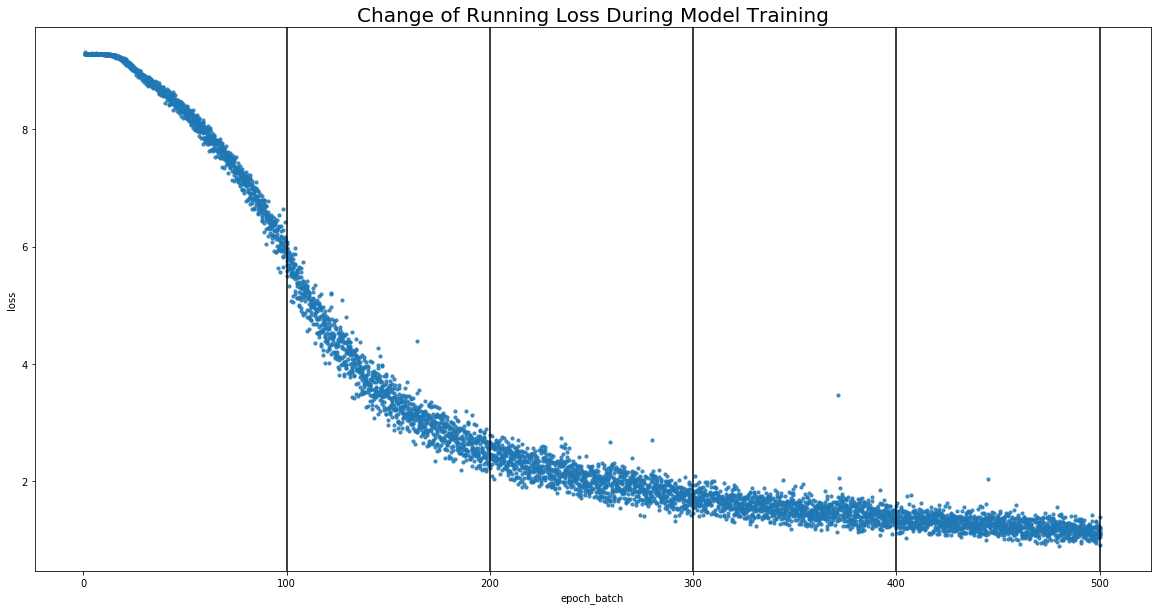

In [70]:
fig,ax = plt.subplots(figsize = (20,10))
sns.regplot(x='epoch_batch',y='loss',data=loss,fit_reg=False,scatter_kws={'s':10}) 
ax.set_title('Change of Running Loss During Model Training', fontsize = 20)
for x in [100,200,300,400,500]:
    plt.axvline(x, color = 'black')

# Visualize runtime spent

In [75]:
os.chdir("C:/TalkingData/PackageName Combine")
runtime = pd.read_csv('./log/4conv_500iter_runtime',names=['epoch','runtime_minutes'])

In [76]:
runtime.tail(5)

,epoch,runtime_minutes
495,496,2.56
496,497,2.56
497,498,2.55
498,499,2.55
499,500,2.56


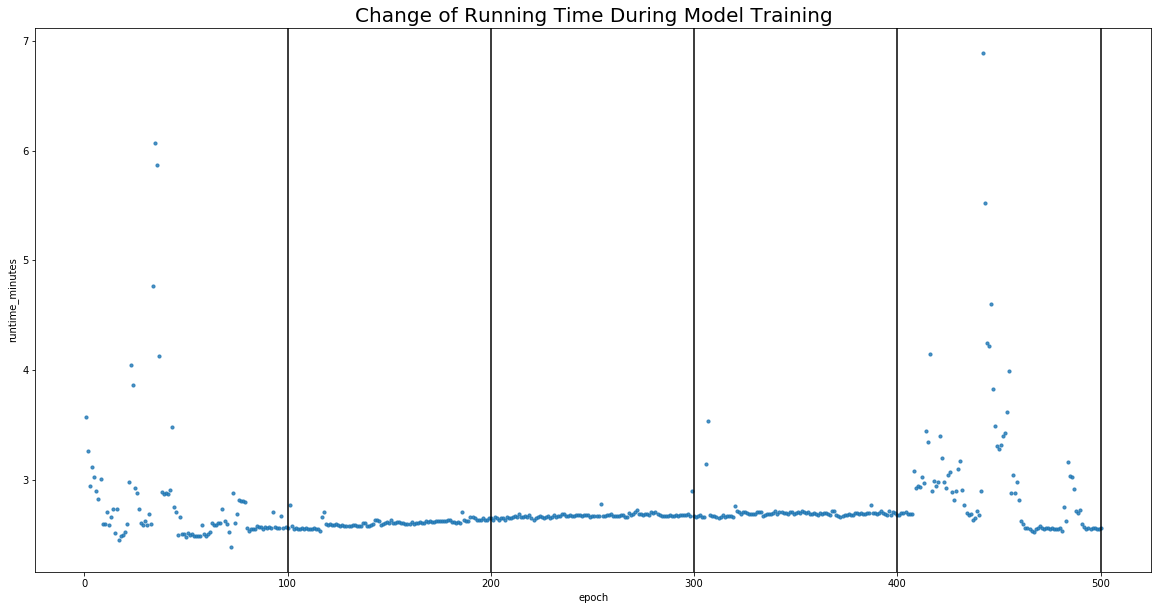

In [77]:
fig,ax = plt.subplots(figsize = (20,10))
sns.regplot(x='epoch',y='runtime_minutes',data=runtime,fit_reg=False,scatter_kws={'s':10}) 
ax.set_title('Change of Running Time During Model Training', fontsize = 20)
for x in [100,200,300,400,500]:
    plt.axvline(x, color = 'black')

# Model Accuracy on Training Data

In [20]:
start = time.time()
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
end = time.time()
print('Calculation time: %.2f seconds' %(end-start))
print('Accuracy of the network on the 10826 train images: %f %%' % (100 * correct / total))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Calculation time: 59.85 seconds
Accuracy of the network on the 10826 train images: 83.995059 %


# Prediction on trained images

GroundTruth:   4919  1888  6955  1981


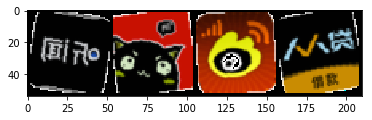

In [50]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images = images[0:4]
labels = labels[0:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].tolist() for j in range(4)))

In [51]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].tolist()
                              for j in range(4)))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Predicted:   9884  1888  6955  1981


In [54]:
# See the top 5 possible metaid and their associated confidence value
torch.topk(outputs,5)

(tensor([[-1.2663e+00, -2.6550e+00, -3.3583e+00, -3.3789e+00, -3.4662e+00],
         [-6.3369e-05, -1.0943e+01, -1.0962e+01, -1.1006e+01, -1.2259e+01],
         [-1.5480e-07, -1.6485e+01, -1.7049e+01, -1.7577e+01, -1.8118e+01],
         [-7.5410e-01, -1.1552e+00, -2.4088e+00, -2.8878e+00, -4.0192e+00]]),
 tensor([[  9884,   4919,   8457,   9773,   2666],
         [  1888,   4593,  10789,   2281,   6656],
         [  6955,    473,   2177,   7963,   5979],
         [  1981,   1648,   6600,   9228,   4796]]))

In [55]:
# Convert the confidence value to possibility
pred_value = torch.topk(outputs,5)[0].tolist()
for i in range(len(pred_value)):
    print([exp(x) for x in pred_value[i]])

[0.2818637295284362, 0.07029739928399684, 0.03479595292373007, 0.03408573032972819, 0.031234349952656185]
[0.9999366327679909, 1.7683058587672172e-05, 1.7347719792825717e-05, 1.6598204199706023e-05, 4.743634013379888e-06]
[0.9999998451983436, 6.928490626241326e-08, 3.9413549297305894e-08, 2.3242443543965703e-08, 1.3531570089541493e-08]
[0.47043242911548094, 0.31499115074828715, 0.08991898866905568, 0.05569922694769986, 0.017967986927117274]


Original metaid: 14806


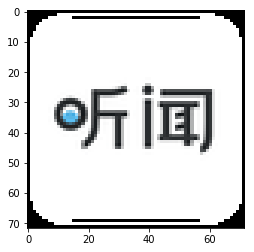

In [53]:
origid = y_metaid['4919']
print('Original metaid: %s' % (origid))
orig = cv2.imread("C:/TalkingData/PackageName Combine/train/{}_1.jpg".format(origid),cv2.IMREAD_UNCHANGED)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(orig)

Predicted metaid: 744


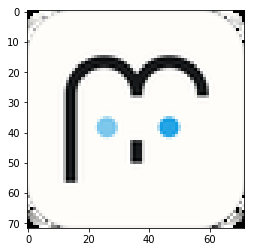

In [52]:
predid = y_metaid['9884']
print('Predicted metaid: %s' % (predid))
pred = cv2.imread("C:/TalkingData/PackageName Combine/train/{}_1.jpg".format(predid),cv2.IMREAD_UNCHANGED)
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
plt.imshow(pred)

# Prediction on test images

In [19]:
# rootdir = "C:/TalkingData/PackageName Combine/test"
# os.chdir(rootdir)

In [22]:
# # Empty target file
# filepath = "./new_image_for_old_app"
# fileList = os.listdir(filepath)
# if fileList:
#     keyboard_input = input("The output folder has existed files. Do you want to empty the folder? (y/n)")
#     if keyboard_input.lower() == 'y':
#         # Empty every file in the folder
#         for fileName in fileList:
#             os.remove(filepath + "/" + fileName)
#         print("\nAll files in the output folder has been wiped out!\n")
#     elif keyboard_input.lower() == 'n':
#         print("\nTake your time to deal with those files :)")
#     else:
#         print("\nPlease enter either y or n")

In [21]:
# # Empty target file
# filepath = "./image_for_new_app"
# fileList = os.listdir(filepath)
# if fileList:
#     keyboard_input = input("The output folder has existed files. Do you want to empty the folder? (y/n)")
#     if keyboard_input.lower() == 'y':
#         # Empty every file in the folder
#         for fileName in fileList:
#             os.remove(filepath + "/" + fileName)
#         print("\nAll files in the output folder has been wiped out!\n")
#     elif keyboard_input.lower() == 'n':
#         print("\nTake your time to deal with those files :)")
#     else:
#         print("\nPlease enter either y or n")

In [20]:
# # Split test images into two categories:
# # 1. image for new app
# # 2. new image for old app
# filelist = os.listdir()
# for filename in tqdm(filelist):
#     if (filename != "image_for_new_app") & (filename != "new_image_for_old_app"):
#         label = filename.split("_")[0]
#         try:
#             # Try find metaid in "metaid_y"
#             # If value found, this is a new image for old app. Otherwise, this is a image for new app
#             label = metaid_y[label]
#             srcfile = os.path.join(rootdir, filename)
#             dstdir = os.path.join("./new_image_for_old_app", filename)
#             shutil.copy(srcfile,dstdir)
#         except:
#             srcfile = os.path.join(rootdir, filename)
#             dstdir = os.path.join("./image_for_new_app", filename)
#             shutil.copy(srcfile,dstdir)

In [56]:
test_oldApp = IconDataset("C:/TalkingData/PackageName Combine/test/new_image_for_old_app",
                          transform = transforms.Compose([
                              CleanImage(),
                              transforms.ToPILImage(),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(10),
                              transforms.Resize([50,50]),
                              ToTensor()
                          ]))
testloader_oldApp = DataLoader(test_oldApp, batch_size = 10, shuffle = True)

In [57]:
class test_newApp(Dataset):
    
    def __init__(self, root_dir, transform = None):
        self.file_list = os.listdir(root_dir)
        self.transform = transform
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        os.chdir(self.root_dir)
        img_name = self.file_list[idx]
        label = img_name.split("_")[0]
        try:
            label = metaid_y[label]
        except:
            label
        label = np.array(label, dtype=np.int64)
        label = torch.from_numpy(label)
        
        # First try cv2 for reading image
        try:
            image = cv2.imread(img_name,cv2.IMREAD_UNCHANGED)
            
            # Sometimes cv2 is fucked-up but does not raise any warning until you call that variable, and u will find NoneType
            if image is None:
                try:
                    image = io.imread(img_name)
                except Exception as err:
                    # For debug
                    print('Both cv2 and skimage failed to read in. Label num: {}'.format(label))  
                    raise err
        # If cv2 doesn't work, try skimage
        except:
            try:
                image = io.imread(img_name)
            # If it still doesn't work, print out the label (first part in filename) for debug
            except:
                # For debug
                print('Both cv2 and skimage failed to read in. Label num: {}'.format(label)) 
                raise err
        
        if self.transform:
            try:
                image = self.transform(image)
            except Exception as err:
                # For debug
                print(image.shape)
                print('Unable to perform transformation.\nimage type:{}\timage shape:{}\tLabel num: {}'.format(
                    type(image),image.shape,label)) 
                raise err

        
        sample = [image,label]
        
        return sample

In [58]:
test_newApp = test_newApp("C:/TalkingData/PackageName Combine/test/image_for_new_app",
                          transform = transforms.Compose([
                              CleanImage(),
                              transforms.ToPILImage(),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(10),
                              transforms.Resize([50,50]),
                              ToTensor()
                          ]))
testloader_newApp = DataLoader(test_newApp, batch_size = 10, shuffle = True)

## Prediction on images for new app

In [59]:
start = time.time()
score = []

with torch.no_grad():
    for data in testloader_newApp:
        images, labels = data
        outputs = net(images)
        scores = [exp(x) for x in torch.topk(outputs,1)[0]]
        score.extend(scores)
end = time.time()
print('Calculation time: %.2f seconds' %(end-start))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Calculation time: 28.84 seconds


(0, 1)

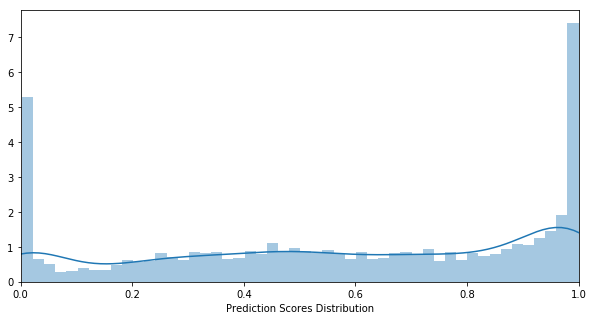

In [60]:
fig,ax = plt.subplots(figsize = (10,5))
sns.distplot(score,bins=50,axlabel='Prediction Scores Distribution').set_xlim(0,1)

## Prediction on new images for old app

In [61]:
start = time.time()
correct = 0
total = 0
correct_score = []
incorrect_score = []
compare_images = pd.DataFrame(columns=['orig','pred','orig_id','pred_id','correct'])

error_counter = 0

with torch.no_grad():
    for data in testloader_oldApp:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        correct_index = [bool(x) for x in (predicted == labels).tolist()]
        incorrect_index = [not x for x in correct_index]
        scores = [exp(x) for x in torch.topk(outputs,1)[0]]
        correct_score.extend(list(compress(scores,correct_index)))
        incorrect_score.extend(list(compress(scores,incorrect_index)))
        
        for i in range(list(labels.size())[0]):
            orig_id = y_metaid[str(labels.tolist()[i])]
            pred_id = y_metaid[str(predicted.tolist()[i])]
            try:
                filename = glob.glob("C:/TalkingData/PackageName Combine/test/{}_[1-9].jpg".format(orig_id))[0]
            except Exception as err:
                error_counter +=1
                next
            orig_image = cv2.imread(filename,cv2.IMREAD_UNCHANGED)
            orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
            orig_m_image = np.transpose(images[i].numpy(),(1,2,0))            
            # Get the filename of any image from this metaid
            filename = glob.glob("C:/TalkingData/PackageName Combine/train/{}_[1-9].jpg".format(pred_id))[0]
            try:
                pred_image = cv2.imread(filename,cv2.IMREAD_UNCHANGED)
                pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
            except Exception as err:
                print(pred_id)
                print(pred_image.shape)
                raise err
            # Add value to dataframe
            compare_images = compare_images.append({'orig_m':orig_m_image,'orig':orig_image,'pred':pred_image,
                                                    'orig_id':orig_id,
                                                    'pred_id':pred_id,
                                                    'correct':correct_index[i]},
                                                  ignore_index=True)
        
end = time.time()
print('Calculation time: %.2f seconds' %(end-start))
print('Accuracy of the network on the 384 new images for old app: %f %%' % (100 * correct / total))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Calculation time: 21.20 seconds
Accuracy of the network on the 384 new images for old app: 49.739583 %


In [63]:
# How many distinct classes we are actually predicting
len(compare_images.orig_id.unique())

349

The performance on new images for old app is not ideal. But it is still doing a lot better than random guessing. The accuracy for random guessing should be 1/349 = 0.2865%. 

Despite the fact that there are also a few images that:
1. Incorrectly labeled at the first place (during the human label stage)
2. Just look exactly the same from visual (two icon images that should belong to different metaid)

(0, 1)

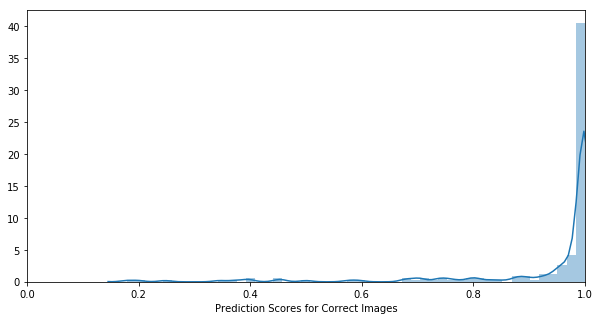

In [64]:
fig,ax = plt.subplots(figsize = (10,5))
sns.distplot(correct_score,bins=50,axlabel='Prediction Scores for Correct Images').set_xlim(0,1)

(0, 1)

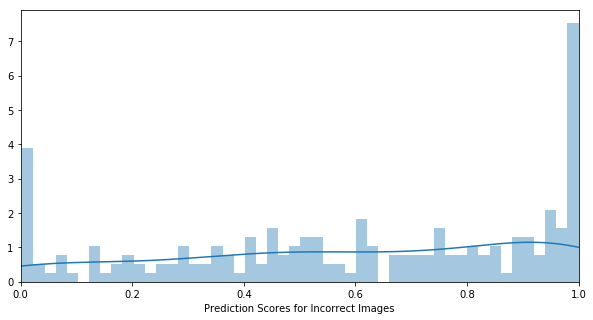

In [65]:
fig,ax = plt.subplots(figsize = (10,5))
sns.distplot(incorrect_score,bins=50,axlabel='Prediction Scores for Incorrect Images').set_xlim(0,1)

In [66]:
def showImages(df):
    '''This function takes in the compare_image dataframe. It compares the original image and prediction pair by pair.
    
       Press "Enter" key to proceed viewing the next pair of images.
       Type in "q" to quit viewing images
    '''
    df = df.reset_index(drop=True)  
    
    for i in range(df.shape[0]):
        print('Viewed Images:{},Left Images:{}'.format(i,df.shape[0]-i))
        print('Labels:\t%s\t%s' % (df.orig_id[i],df.pred_id[i]))
        image_list = [df.orig_m[i],df.orig[i],df.pred[i]]
        
        fig, ax = plt.subplots(1, len(image_list), figsize=(10, 12))        
        for j, _img in enumerate(image_list):
            ax[j].imshow(_img)
        
        plt.show()
        
        user = input("Press Enter to proceed the next pair of images.")
        # If user types in "q"
        if user == "q":
            print("Quit viewing images.")
            return
        # If user press "Enter" key
        if user == "":
            # Clear the code chunk output so images don't stack up
            clear_output()
            next
        while(user !=""):
            print("Please press enter.")
            user = input("Press Enter to proceed the next pair of images.")    

Viewed Images:6,Left Images:188
Labels:	5289	100159


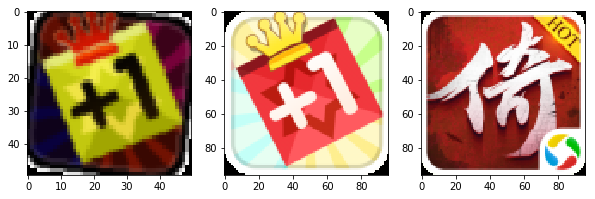

Press Enter to proceed the next pair of images.q
Quit viewing images.


In [42]:
# Compare wrong prediction images with the original image

# The first label is the real metaid and the second label is the predicted metaid

# The left most image is the image model receives (after various transformations)
# The middle image is the original image
# The right most image is the image corresponds to the predicted metaid

showImages(compare_images[compare_images.correct==False])

Viewed Images:3,Left Images:187
Labels:	116343	116343


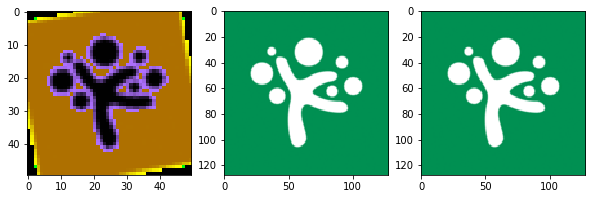

Press Enter to proceed the next pair of images.q
Quit viewing images.


In [41]:
showImages(compare_images[compare_images.correct==True])